In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
file_path = 'ML-EdgeIIoT-dataset.csv'
dataset = pd.read_csv(file_path, encoding='latin-1')
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157800 entries, 0 to 157799
Data columns (total 63 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   frame.time                 157800 non-null  object 
 1   ip.src_host                157800 non-null  object 
 2   ip.dst_host                157800 non-null  object 
 3   arp.dst.proto_ipv4         157800 non-null  object 
 4   arp.opcode                 157800 non-null  float64
 5   arp.hw.size                157800 non-null  float64
 6   arp.src.proto_ipv4         157800 non-null  object 
 7   icmp.checksum              157800 non-null  float64
 8   icmp.seq_le                157800 non-null  float64
 9   icmp.transmit_timestamp    157800 non-null  float64
 10  icmp.unused                157800 non-null  float64
 11  http.file_data             157800 non-null  object 
 12  http.content_length        157800 non-null  float64
 13  http.request.uri.query     15

In [3]:
# Drop unnecessary columns
dataset = dataset.drop(['frame.time', 'ip.src_host'], axis=1)

In [4]:
# Handle non-numeric data by encoding categorical features
label_encoders = {}
for column in dataset.columns:
    if dataset[column].dtype == 'object':
        le = LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column].astype(str))
        label_encoders[column] = le

In [5]:
# Replace '?' with NaN and handle missing values
dataset.replace('?', np.nan, inplace=True)
dataset.dropna(inplace=True)

# Split data into features (X) and target (y)
X = dataset.drop(columns=['Attack_type'])
y = dataset['Attack_type']

In [6]:
# Encode the target variable if it's categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [7]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train Logistic Regression model
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)

# Define and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

# Define and train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=50, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=50, random_state=42)

3452/3452 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step

Final Results (Table 4):
                      Model       AUC  Accuracy  F1-Score
0       Logistic Regression  0.995936  0.928116  0.928116
1             Random Forest  0.999953  0.997064  0.997064
2         Gradient Boosting  0.999951  0.996768  0.996768
3             Deep Learning  0.999634  0.986333  0.986333
4   SL1: DL as meta-learner  0.999951  0.996472  0.996472
5  SL2: GBM as meta-learner  0.943483  0.991508  0.991508


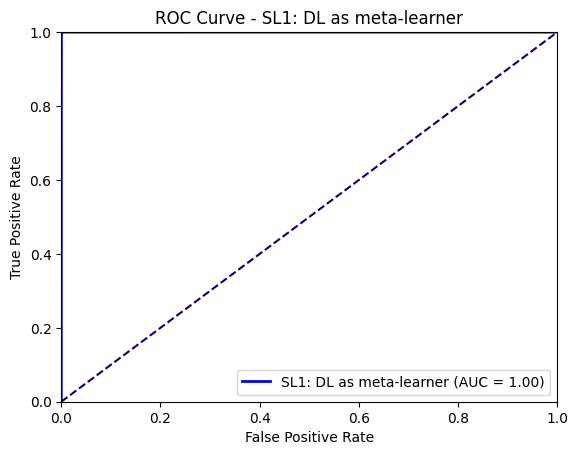

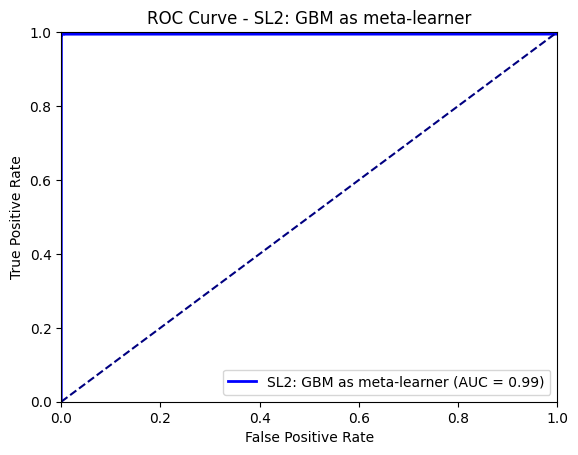

In [9]:
# Define and train Deep Learning model
def create_dl_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

dl_model = create_dl_model()
dl_model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)

# Predict with the deep learning model
y_pred_dl_train = dl_model.predict(X_train)
y_pred_dl_test = dl_model.predict(X_test)

# Create SL1 Stacking model with DL as the meta-learner
sl1_estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42))
]

# Add DL predictions as a new feature
X_train_sl1 = np.hstack((X_train, y_pred_dl_train))
X_test_sl1 = np.hstack((X_test, y_pred_dl_test))

sl1_model = StackingClassifier(estimators=sl1_estimators, final_estimator=LogisticRegression(max_iter=100))
sl1_model.fit(X_train_sl1, y_train)

# Create SL2 Stacking model with GBM as the meta-learner
sl2_estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42))
]

sl2_model = StackingClassifier(estimators=sl2_estimators, final_estimator=GradientBoostingClassifier(n_estimators=50, random_state=42))
sl2_model.fit(X_train_sl1, y_train)

# Define the models dictionary
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Deep Learning': dl_model,  # We'll handle this separately for DL
    'SL1: DL as meta-learner': sl1_model,
    'SL2: GBM as meta-learner': sl2_model
}

# Binarize the labels for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(np.unique(y))))

# Evaluate the models and store results
results = []
roc_curves = {}

for name, model in models.items():
    if name == 'Deep Learning':
        y_pred = y_pred_dl_test
    else:
        if 'SL1' in name:
            y_pred = model.predict_proba(X_test_sl1)
        elif 'SL2' in name:
            y_pred = model.predict_proba(X_test_sl1)
        else:
            y_pred = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, np.argmax(y_pred, axis=1))
    f1 = f1_score(y_test, np.argmax(y_pred, axis=1), average='micro')

    # Calculate ROC AUC score based on the problem type
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred[:, 1])
    else:
        roc_auc = roc_auc_score(y_test_bin, y_pred, multi_class='ovr')

    results.append({
        'Model': name,
        'AUC': roc_auc,
        'Accuracy': accuracy,
        'F1-Score': f1
    })

    # ROC curve data
    if len(np.unique(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
        roc_curves[name] = (fpr, tpr, roc_auc)
    else:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(np.unique(y_test))):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        roc_curves[name] = (fpr, tpr, roc_auc)

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print("\nFinal Results (Table 4):")
print(results_df)

# Plot ROC curves for SL1 and SL2
for model_name in ['SL1: DL as meta-learner', 'SL2: GBM as meta-learner']:
    plt.figure()
    fpr, tpr, roc_auc = roc_curves[model_name]
    if isinstance(fpr, dict):
        plt.plot(fpr["micro"], tpr["micro"], color='blue', lw=2,
                 label=f'{model_name} (AUC = {roc_auc["micro"]:.2f})')
    else:
        plt.plot(fpr, tpr, color='blue', lw=2,
                 label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Define and train SVM model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Define and train XGBoost model
xgb_model = XGBClassifier(n_estimators=50, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

3452/3452 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step

Final Results (Table 4):
                          Model       AUC  Accuracy  F1-Score
0           Logistic Regression  0.995936  0.928116  0.928116
1                           SVM  0.998195  0.968504  0.968504
2                       XGBoost  0.999947  0.996662  0.996662
3                 Deep Learning  0.999625  0.978940  0.978940
4       SL1: DL as meta-learner  0.999941  0.996578  0.996578
5  SL2: XGBoost as meta-learner  0.999671  0.985425  0.985425


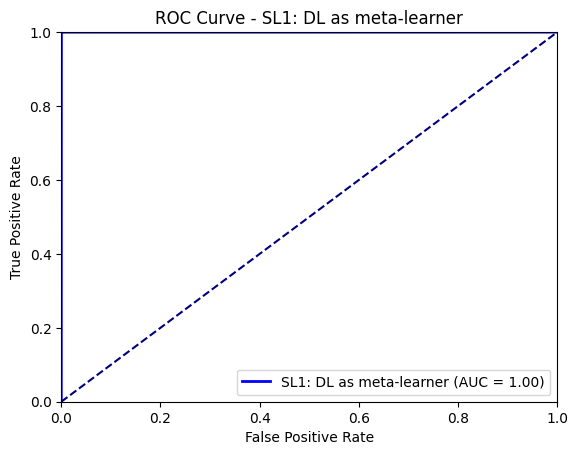

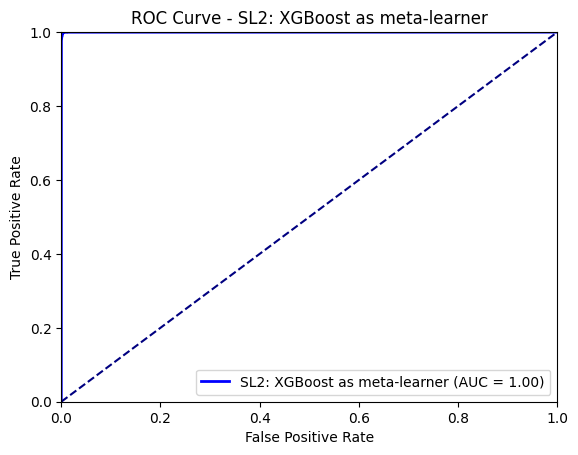

In [11]:
# Define and train Deep Learning model
def create_dl_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

dl_model = create_dl_model()
dl_model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)

# Predict with the deep learning model
y_pred_dl_train = dl_model.predict(X_train)
y_pred_dl_test = dl_model.predict(X_test)

# Create SL1 Stacking model with DL as the meta-learner
sl1_estimators = [
    ('svm', SVC(probability=True, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=50, random_state=42))
]

# Add DL predictions as a new feature
X_train_sl1 = np.hstack((X_train, y_pred_dl_train))
X_test_sl1 = np.hstack((X_test, y_pred_dl_test))

sl1_model = StackingClassifier(estimators=sl1_estimators, final_estimator=LogisticRegression(max_iter=100))
sl1_model.fit(X_train_sl1, y_train)

# Create SL2 Stacking model with XGBoost as the meta-learner
sl2_estimators = [
    ('svm', SVC(probability=True, random_state=42))
]

sl2_model = StackingClassifier(estimators=sl2_estimators, final_estimator=XGBClassifier(n_estimators=50, random_state=42))
sl2_model.fit(X_train_sl1, y_train)

# Define the models dictionary
models = {
    'Logistic Regression': lr_model,
    'SVM': svm_model,
    'XGBoost': xgb_model,
    'Deep Learning': dl_model,  # We'll handle this separately for DL
    'SL1: DL as meta-learner': sl1_model,
    'SL2: XGBoost as meta-learner': sl2_model
}

# Binarize the labels for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(np.unique(y))))

# Evaluate the models and store results
results = []
roc_curves = {}

for name, model in models.items():
    if name == 'Deep Learning':
        y_pred = y_pred_dl_test
    else:
        if 'SL1' in name:
            y_pred = model.predict_proba(X_test_sl1)
        elif 'SL2' in name:
            y_pred = model.predict_proba(X_test_sl1)
        else:
            y_pred = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, np.argmax(y_pred, axis=1))
    f1 = f1_score(y_test, np.argmax(y_pred, axis=1), average='micro')

    # Calculate ROC AUC score based on the problem type
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred[:, 1])
    else:
        roc_auc = roc_auc_score(y_test_bin, y_pred, multi_class='ovr')

    results.append({
        'Model': name,
        'AUC': roc_auc,
        'Accuracy': accuracy,
        'F1-Score': f1
    })

    # ROC curve data
    if len(np.unique(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
        roc_curves[name] = (fpr, tpr, roc_auc)
    else:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(np.unique(y_test))):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        roc_curves[name] = (fpr, tpr, roc_auc)

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print("\nFinal Results (Table 4):")
print(results_df)

# Plot ROC curves for SL1 and SL2
for model_name in ['SL1: DL as meta-learner', 'SL2: XGBoost as meta-learner']:
    plt.figure()
    fpr, tpr, roc_auc = roc_curves[model_name]
    if isinstance(fpr, dict):
        plt.plot(fpr["micro"], tpr["micro"], color='blue', lw=2,
                 label=f'{model_name} (AUC = {roc_auc["micro"]:.2f})')
    else:
        plt.plot(fpr, tpr, color='blue', lw=2,
                 label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
